# Bayesian analysis of the empirical saturation point

In this notebook, we present the main results of our manuscript, using the conjugate prior approach.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

First, let us plot all available DFT constraints:

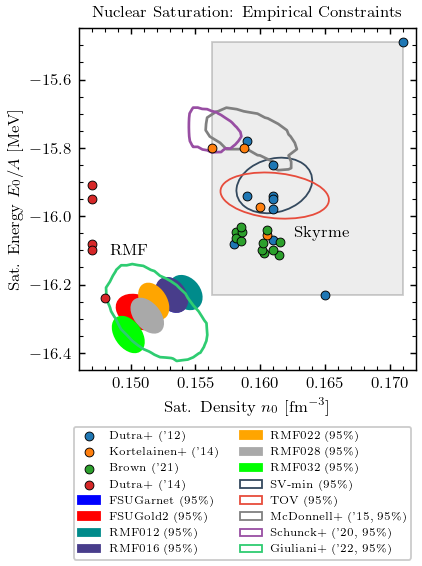

In [2]:
from modules.SaturationAnalysis import SaturationAnalysis
analysis = SaturationAnalysis()
analysis.plot_constraints(eft=False, eft_conf_level=0.95)

The PDFs generated in this notebook are by default output to the directory `./pdf`.

 ## Priors

Next, let's take a look at the priors used in this work. They can be specified in the file `modules/priors.py`.

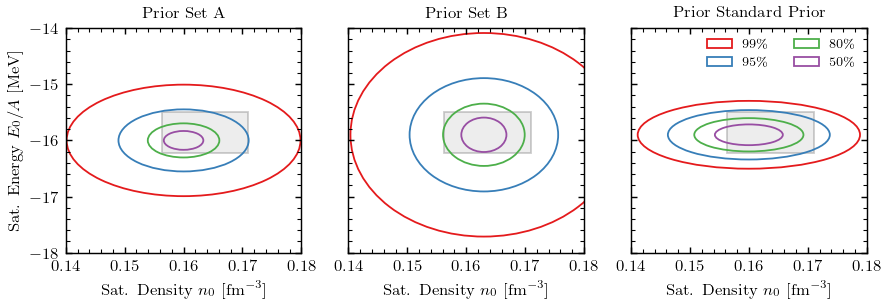

In [3]:
from modules.SaturationAnalysis import visualize_priors
from modules.priors import *
fig, axs = visualize_priors(used_prior_sets)
fig.savefig("pdf/prior_sets.pdf")

We use the two priors on the left (dubbed A and B) to investigate the prior sensitivity of our Bayesian inference.

## Saturation box in Drischler *et al.* (2016)

Moving on, we will now study the saturation box constructed by Drischler *et al.* (2016), which encompasses the range of several energy density functionals:

number of data point(s): 14


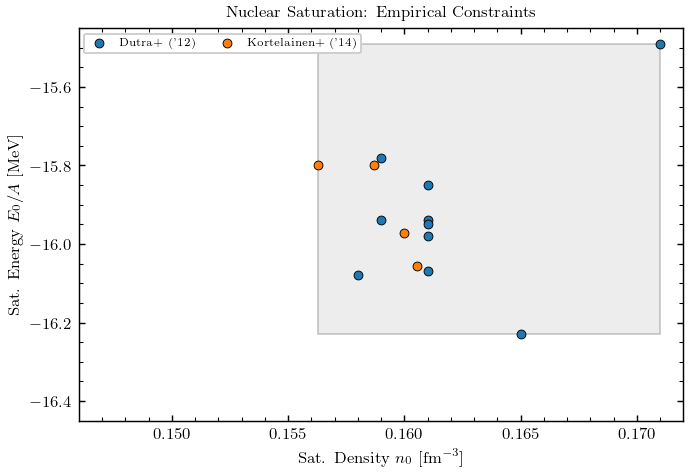

In [4]:
from modules.SaturationAnalysis import drischler_satbox
print(f"number of data point(s):", len(drischler_satbox.data_frame))
drischler_satbox.plot(plot_box_estimate=True, legend_out_of_frame=False)

The gray box depictes the saturation box. One can see that the DFT constraints are clustered at the lower-left corner of the box; i.e., without the single points in the upper-right corner the saturation box would be significantly smaller and shifted towards lower saturation densities and ground-state energies.

Next, we apply our statistical methodd to these data (without uncertainties). We plot both the prior predictive, which is completely data-agnostic, and the posterior predictive for the three prior choices we have made:

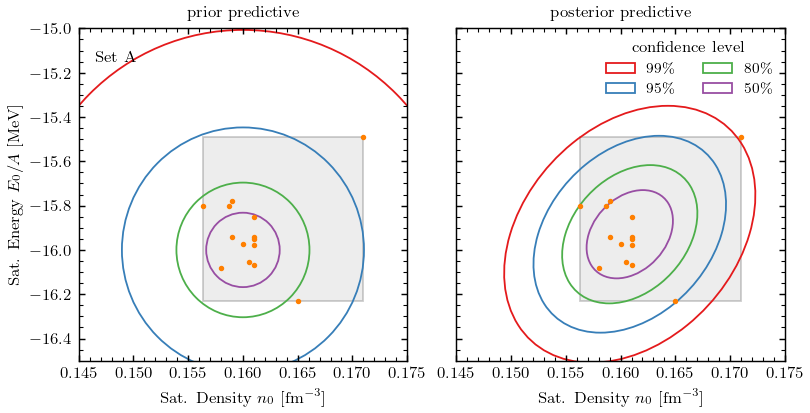

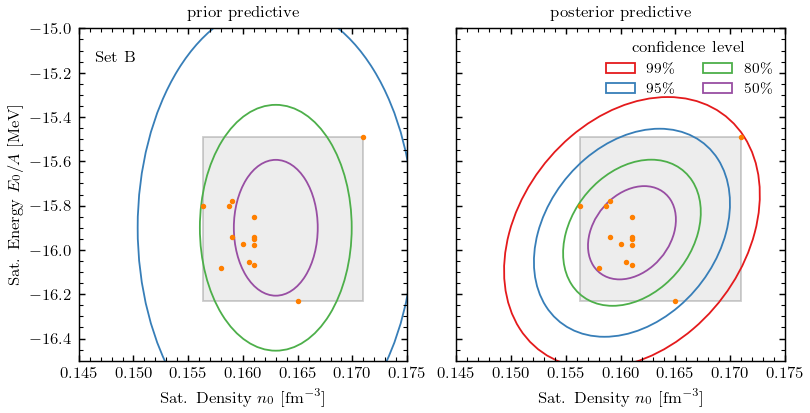

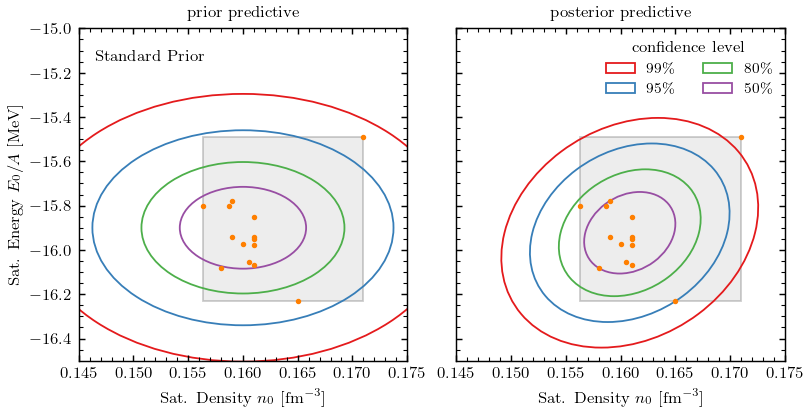

In [5]:
from modules.StatisticalModel import StatisticalModel
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    fig, _ = model.plot_predictives(validate=False)
    fig.savefig(f"pdf/overview_analysis_satbox_{label_filename(prior_set['label'])}.pdf")

More informative are corner plots of the prior and posterior predictives generated in the previous step. They show the two marginal distributions. Let's make corner plots:

Set A (17, array([  0.16083667, -15.9292    ]), array([[1.07708821e-05, 1.65382275e-04],
       [1.65382275e-04, 2.74842604e-02]]))
Set B (17, array([  0.16103667, -15.92253333]), array([[1.11649213e-05, 1.64374170e-04],
       [1.64374170e-04, 3.06951362e-02]]))
Standard Prior (23, array([  0.16083667, -15.92253333]), array([[1.21535505e-05, 1.18358879e-04],
       [1.18358879e-04, 2.37265500e-02]]))


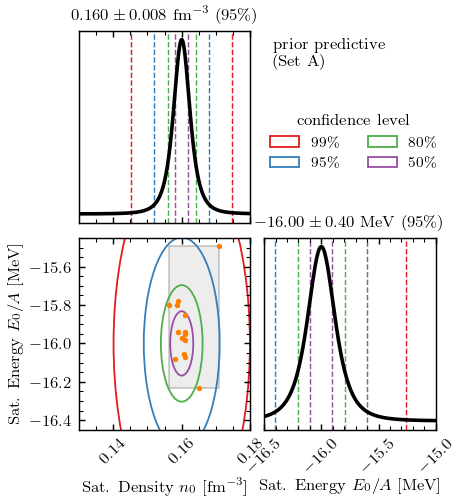

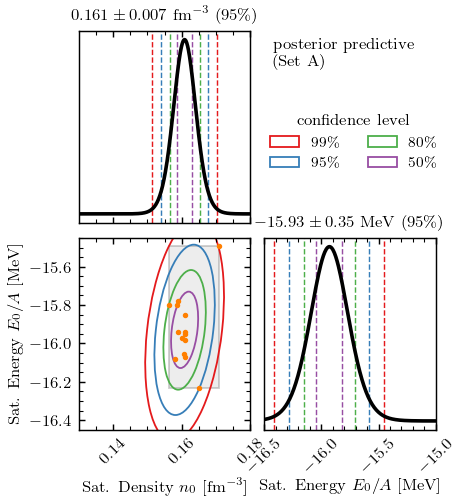

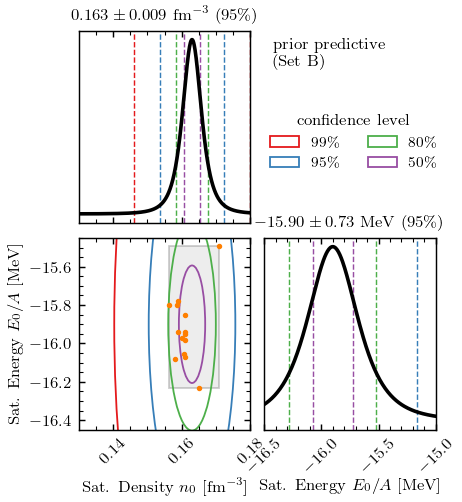

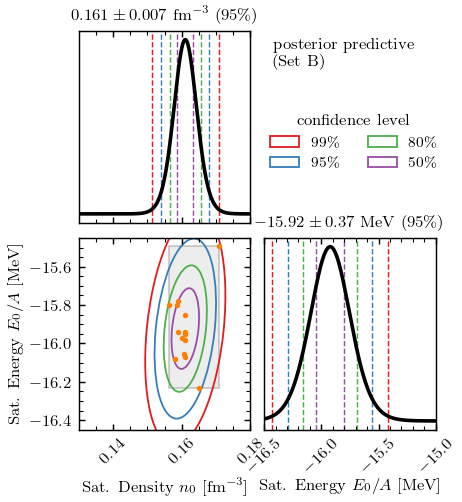

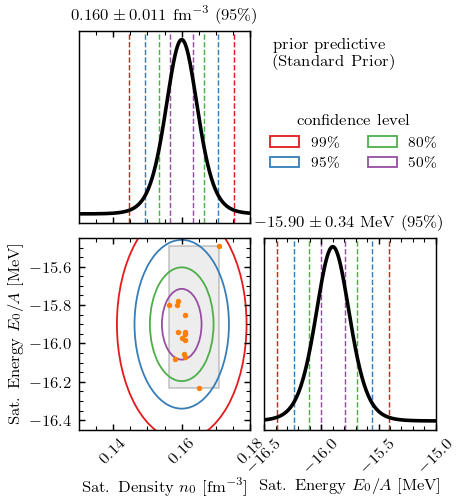

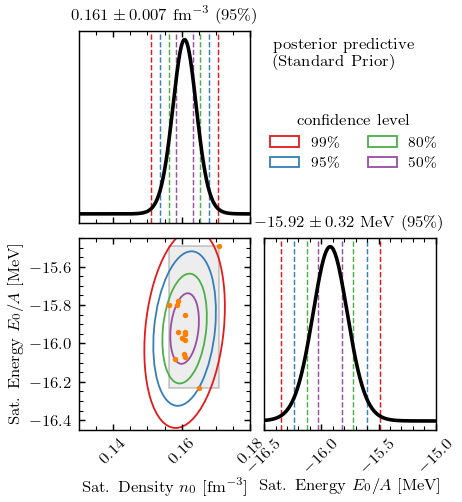

In [6]:
import matplotlib.backends.backend_pdf
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    ret = model.plot_predictives_corner()
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_{label_filename(prior_set['label'])}.pdf")
    print(prior_set['label'], model.predictives_params())
    for elem in ret:
        fig, axs = elem
        pdf.savefig(fig)
    pdf.close()

Note that the prior used is annotated in each figures.

Generating the corner plot did not require any sampling of the distribution functions. Only (semi-)analytic calculations. Let's check our implementation brute-force using sampling:

Set A (17, array([  0.16083667, -15.9292    ]), array([[1.07708821e-05, 1.65382275e-04],
       [1.65382275e-04, 2.74842604e-02]]))
Set B (17, array([  0.16103667, -15.92253333]), array([[1.11649213e-05, 1.64374170e-04],
       [1.64374170e-04, 3.06951362e-02]]))
Standard Prior (23, array([  0.16083667, -15.92253333]), array([[1.21535505e-05, 1.18358879e-04],
       [1.18358879e-04, 2.37265500e-02]]))


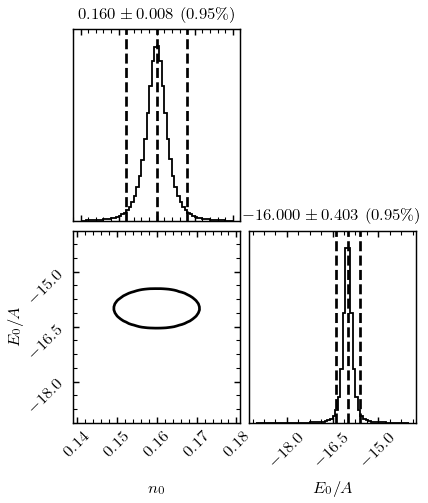

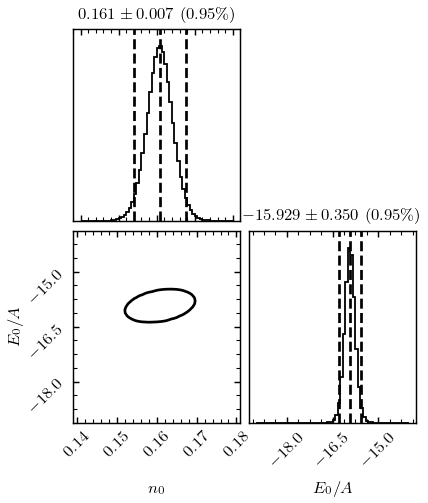

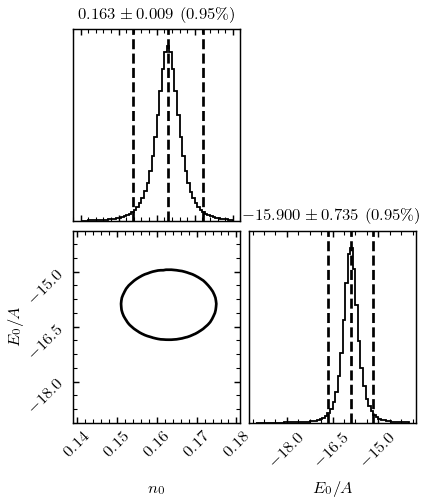

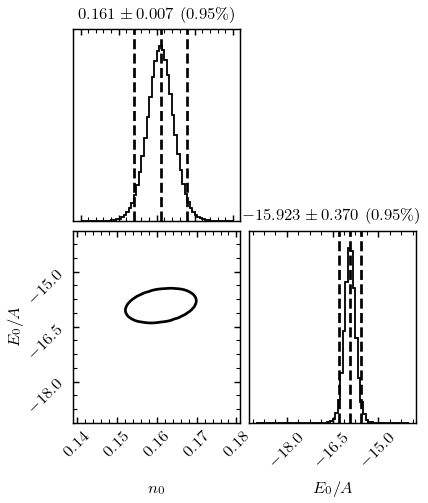

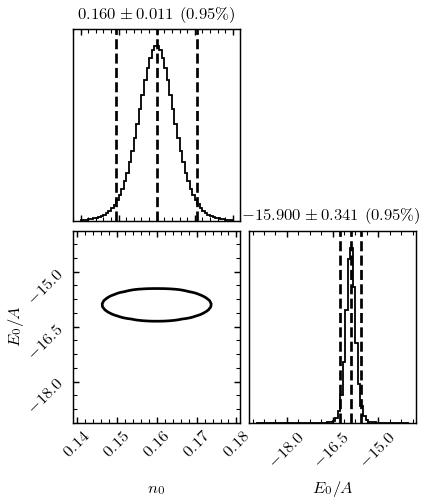

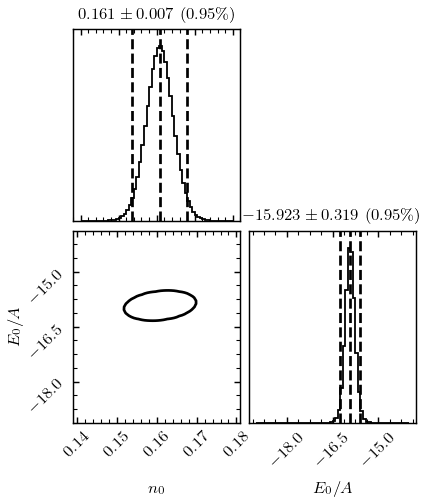

In [7]:
import matplotlib.backends.backend_pdf
for prior_set in used_prior_sets:
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    ret = model.plot_predictives_corner_bf()
    pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_bf_{label_filename(prior_set['label'])}.pdf")
    print(prior_set['label'], model.predictives_params())
    for elem in ret:
        fig, axs = elem
        pdf.savefig(fig)
    pdf.close()

The results match well. However, the Python package `corner` has a known bug (see the comments in this repository for more details). The percentiles in the titles are always the default ones. We have fixed the issue by computing the percentiles separately. The percentiles above correspond to the 95% confidence level.

Alternatively, we apply our Monte Carlo sampling strategy described in the manuscript to this data set (without uncertainties). We simply run one Monte Carlo iteration (`num_realizations=1`) with `num_samples_mu_Sigma=100000` samples of the posterior predictive. We let one worker do the job (req_num_workers=1)--or we could do the sampling in batches.

In [8]:
from modules.DataSets import Scenario
from modules.SaturationAnalysis import drischler_satbox

scenarioX = Scenario(
    label="Drischler Satbox",
    datasets=[drischler_satbox]
)
npts = len(scenarioX.datasets[0].data_frame)
for prior_set in used_prior_sets:
    fit = analysis.mc_iterate(
        scenario=scenarioX,
        num_realizations=1,
        num_pts_per_dft_model=1,
        num_samples_mu_Sigma=100000,
        req_num_workers=1,
        sample_replace=True,
        plot_iter_results=False,
        prior_params=prior_set,
        debug=False,
        plot_fitted_conf_regions=True
    )
    print(prior_set["label"], fit)

Number of workers used for mixture model sampling: 1 (max: 8)
Sampling using 1 batches with sizes: [1]
Worker with pid 76814 [SpawnPoolWorker-1 (1,)] initialized.
	Required time for generating all DFT realizations [76814]: 0.003655 s
	Required time for sampling 1 mixture models [76814]: 0.021135 s
Required time for generating all 100000 posterior samples: 5.409453 s
Results written to './pdf/mc_output_1_drischler-satbox_set_a_num_postersamples_100000_num_mciter_1.pdf'
{'mu': array([  0.16049133, -16.03532595]), 'Psi': array([[ 3.83369952e-06, -1.01971856e-05],
       [-1.01971856e-05,  9.81779022e-03]]), 'df': 4.0}
Samples written to './pdf/samples_1_drischler-satbox_set_a_num_postersamples_100000_num_mciter_1.h5'.
Set A {'mu': array([  0.16049133, -16.03532595]), 'Psi': array([[ 3.83369952e-06, -1.01971856e-05],
       [-1.01971856e-05,  9.81779022e-03]]), 'df': 4.0}
Number of workers used for mixture model sampling: 1 (max: 8)
Sampling using 1 batches with sizes: [1]
Worker with pid 

## Hierarchical model for data with uncertainties

Now, let's study data DFT constraints with and without uncertainties quantified. We use the Monte Carlo iteration strategy described in the manuscript. Let us first define the data we want to analyze, organized in so-called scenarios:

In [9]:
from modules.DataSets import Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(
    label="FSU-only",
    datasets=[dft_constraints["fsu_rmf"]]
)
scenario2 = Scenario(
    label="FSU+Schunck-only",
    datasets=[dft_constraints["fsu_rmf"], dft_constraints["schunck"]]
)
scenario3 = Scenario(
    label="all-but-FSU",
    datasets=[dft_constraints[lbl] for lbl in dft_constraints.keys() if lbl != "fsu_rmf"]
)
scenario4 = Scenario(
    label="Giuliani+Schunck-only",
    datasets=[dft_constraints["giuliani"], dft_constraints["schunck"]]
)
# scenario1.configs[0].data_set.plot()

Let's run `scenario3`, which includes all constraints but the FSU constraints, as discussed in the manuscript. Execution may take a while but greatly benefits from parallelization. Luckily, this problem is _embarrasingly parallelizable_.

In [10]:
for prior_set in used_prior_sets:
    fit = analysis.mc_iterate(
        scenario=scenario3,
        num_realizations=100000,
        num_pts_per_dft_model=1,
        num_samples_mu_Sigma=100,
        req_num_workers=10,
        sample_replace=True,
        plot_iter_results=False,
        prior_params=prior_set,
        debug=False,
        plot_fitted_conf_regions=True
    )
    print(prior_set["label"], fit)
    # analysis.plot_individual_models()

Number of workers used for mixture model sampling: 8 (max: 8)
Sampling using 8 batches with sizes: [12500, 12500, 12500, 12500, 12500, 12500, 12500, 12500]
Worker with pid 76894 [SpawnPoolWorker-8 (8,)] initialized.
Worker with pid 76895 [SpawnPoolWorker-9 (9,)] initialized.
Worker with pid 76892 [SpawnPoolWorker-6 (6,)] initialized.
Worker with pid 76891 [SpawnPoolWorker-5 (5,)] initialized.
Worker with pid 76896 [SpawnPoolWorker-10 (10,)] initialized.
Worker with pid 76890 [SpawnPoolWorker-4 (4,)] initialized.
Worker with pid 76893 [SpawnPoolWorker-7 (7,)] initialized.
Worker with pid 76897 [SpawnPoolWorker-11 (11,)] initialized.
	Required time for generating all DFT realizations [76892]: 25.011621 s
	Required time for generating all DFT realizations [76895]: 25.202660 s
	Required time for generating all DFT realizations [76894]: 25.371905 s
	Required time for generating all DFT realizations [76896]: 25.138512 s
	Required time for generating all DFT realizations [76891]: 25.241874 s


Note that the PDFs were written to the default directory `./pdf` and the fit results are printed out.

## Benchmarking EFT predictions for the nuclear saturation point

With the empirical saturation points inferred, we can now benchmark microscopic predictions from chiral effective field theory (EFT):

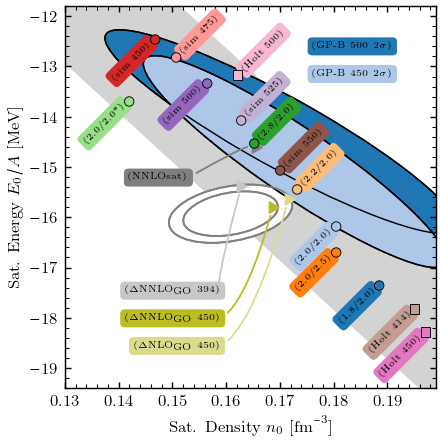

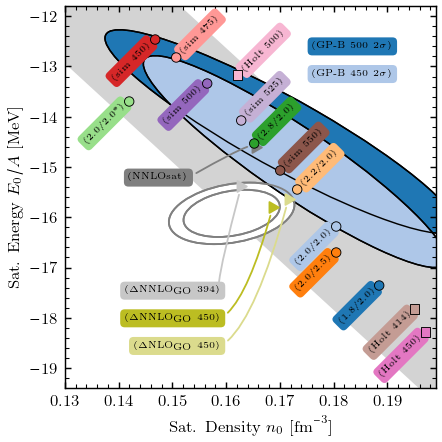

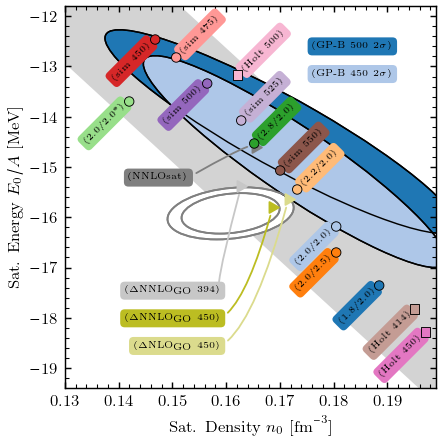

In [11]:
from modules.plot_helpers import cm
import matplotlib.pyplot as plt
from modules.eft_satpoints import make_coester_plot
for prior_set in used_prior_sets:
    fig, ax = plt.subplots(1, 1, figsize=(8.6*cm, 8.6*cm), constrained_layout=True)
    model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=prior_set)
    make_coester_plot(ax,
                      #emp_constraint=drischler_satbox.box_estimate().update({"type": "box"})
                      emp_constraint={"type": "t", **model.predictives_params(return_dict=True)}
                      )
    fig.savefig(f"pdf/eft_satpoints_{label_filename(prior_set['label'])}.pdf")

One can see that the EFT predictions are barely (if at all) consistent with the empirical constraints. The agreement is best for the deltaful chiral potentials, represented by the triangles.

## Symmetry energy at saturation density

The energy per particle in pure neutron matter (in the vicinity of the nuclear saturation density) is typically way better constrained by chiral effective field theory. Let's combine the inferred empirical saturation therefore with pure neutron matter calculations of the energy per neutron $E/N$ and the pressure $P$ in pure neutron matter to constrain the nuclear symmetry energy $S_v$ and its slope parameter $L$ evaluated at the nuclear saturation density. In the standard quadratic approximation, one has:

$$
\begin{align} 
	S_v = \frac{E}{N}(n_0) - \frac{E_0}{A} \quad \text{and} \quad 
% 	L &= 3n_0 \dv{n}\frac{E}{N}(n)\bigg|_{n=n_0} \,.
	L = \frac{3}{n_0} P(n_0)\,,
% P(n_0) &= n^2 \dv{n} \frac{E}{N}(n)\bigg|_{n=n_0} \, ,
\end{align}
$$

Specifically, we use here the neutron matter results obtained by the BUQEYE collaboration (see their [repository](https://github.com/buqeye/nuclear-matter-convergence)) with to-all-orders EFT truncation errors fully quantified.

We extract now $(S_v,L)$ and compare the results with other theoretical predictions, mostly those which follow a similar neutron-matter-based strategy. In addition, we show the recent PREX-II-informed results:

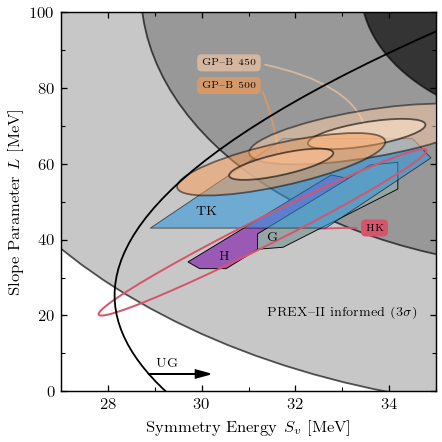

In [13]:
from modules.plot_helpers import cm
from modules.symmetry_energy import make_sv_l_plot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(8.6*cm, 8.6*cm), constrained_layout=True)
make_sv_l_plot(axs)
fig.savefig("pdf/esym.pdf")